<!-- ## import the csv of data from a Wetlands Insight Tool plot
## render the graph
## select the time of interest
## plot the spatial distribution of the WIT classification for the time of interest -->


# Output Spatial Wetlands Insight Maps based off existing Wetlands Insight Tool data

- import csv of a given WIT output
- render graph
- select point on graph 
- plot spatial wit for point
- output to GeoTiff

In [1]:
 %matplotlib widget

In [2]:
#run bokeh
from bokeh.plotting import figure,show
from bokeh.io import output_notebook #outputs bokeh to notebook
output_notebook() #this is the command to tell bokeh to output into the jupyterlab notebook

Loading BokehJS ...

### Import useful libraries

In [3]:
import datacube
import datetime
import fiona
import geopandas as gpd
import os
import glob
import numpy as np
import pandas as pd

import rasterio.mask
import rasterio.features
import seaborn as sns
from shapely import geometry
import sys
import xarray as xr

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from textwrap import wrap

from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from digitalearthau.utils import wofs_fuser


dc = datacube.Datacube(app='wetlands insight tool')
%load_ext autoreload
%autoreload 2

# there are functions in here you need
sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, WetlandsTools, SpatialTools, wetlands_insight

#get the newest version of dea_datahandling. You may need to move the pointer below to your version
sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/Scripts')
import dea_datahandling

dc = datacube.Datacube(app='wetlands insight tool')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#set input directory
# global Input_dir
Input_dir = '/g/data/r78/rjd547/Ramsar_Wetlands/Wetlands_Insight_Tool_v2/'

### list available sites to plot

In [5]:
#change to the input directory
os.chdir(Input_dir)

In [6]:
# #print all files
# for file in glob.glob("*.csv"):
#     print(file)  

to use Emma's Ramsar runs, go to http://terria-cube.terria.io/#share=s-kdYVC1Nmf22OUh3fDa5fYSOOO1K and use the filename of the csv file you can download to work out which of these is your wetland of choice

In [7]:
#alternatively, print the files you want only
search_term = '9'
for file in glob.glob(f"{search_term}.csv"):
    print(file)

9.csv


In [8]:
input_file =  str(file)
print(input_file)

9.csv


In [9]:
#read in your desired csv of the WIT data. Rename the columns so they are easier to understand and plot 
WITdata = pd.read_csv(Input_dir+input_file,
                     index_col=0, infer_datetime_format=True)

#give the index a name that reflects that it is time, measured in UTC not AEDT/AEST
WITdata.index.names = ['utc_time']

#format the index of the dataframe as a date, not as a string
WITdata.index = pd.to_datetime(WITdata.index)
#Rename the columns so they are easier to understand and plot
WITdata = WITdata.rename(columns={"WATER" : "water", 
                        "WET" : "wet",
                       "PV" : "green",
                       "NPV" : "dry",
                       "BS" : "bare"}) 
#WITdata.head()

In [10]:
#converting to percentages to make plotting easier
WITdata = WITdata*100
#WITdata.head()

In [11]:
#set up colour palette for our plots
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]  

### Set up the title for the plot here:

In [12]:
polyName = input_file #change this as appropriate

In [13]:
# #take the name of the polygon and add something else to it
# polyName=search_term+"?"
# polyName=polyName.replace("'","\\'")
# title="\n".join(wrap(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}'))

In [14]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d, Label #use this to set the newWIT graph ranges
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models.glyphs import Text
from bokeh.models import ColumnDataSource
from bokeh.models.tickers import DatetimeTicker

TOOLS = ["pan, wheel_zoom, box_zoom, reset, tap, save"]

def prettierWITplot():
    '''Function to use bokeh to draw a WIT plot.'''
    print('stuff')
    
title =f'Percentage of area dominated by WOfS, Wetness, Fractional Cover for {polyName}'    
       
#set up the x axis to recognise date and time. Note that you will only see the days when you zoom in.
p =figure(plot_width=1200, 
          plot_height = 400, 
          x_axis_type='datetime',
         title=title, tools=TOOLS)
p.sizing_mode = "scale_width"
#align the title in the centre
p.title.align= "center"
p.title.text_font_size="12pt"

#label axes
p.yaxis.axis_label=("percentage of polygon classified as type")
p.yaxis.axis_label_text_font_size="8pt"


# #layout puts things in certain places

#we need screen units to put the attribution label under the plot. Don't ask why.
label_opts = dict(
    x=0, 
    y=0,
    x_units='screen', 
    y_units='screen',
    text_font_style="italic", 
    text_font_size="8.5pt")



msg1 = 'The Fractional Cover algorithm developed by the Joint Remote Sensing Research Program\n\
and the Water Observations from Space algorithm developed by Geoscience Australia are used in the production of this data'
caption1 = Label(text=msg1, **label_opts)

p.add_layout(caption1, 'below')

p.xaxis.formatter=DatetimeTickFormatter(years =["%Y"], months=["%m/%Y"] ,days=["%d/%m/%Y"])
p.xaxis.major_label_orientation = 45

#create the actual stack plot using data from the pandas dataframe with the ingested csv.
p.varea_stack(['water', 
              'wet',
              'green',
              'dry',
              'bare'], x= 'utc_time', color=pal, fill_alpha=0.7, source = WITdata, 
              legend_label=["water","wet","green","dry","bare"], muted_color="grey", muted_alpha=0.2)

	
#set the new WIT graph ranges.
left, right, bottom, top = WITdata.index[0], WITdata.index[-1], 0, 100 #set 
p.x_range=Range1d(left, right)
p.y_range=Range1d(bottom, top)
p.xaxis.bounds=(left,right)
p.yaxis.bounds=(bottom,top)

#now we want to overplot the data on the plot
#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

#plot our dead satellite rectangle
p.hbar(y=50, 
       height=100,
       left=LS5_8_gap_start, 
       right=LS5_8_gap_end, 
       color="white", 
       alpha=0.5, 
       hatch_color="white", 
       hatch_pattern='/',
       hatch_alpha=0.6,
       line_color="white",
       line_width =2,
       line_alpha=0.6)

p.legend
p.legend.location="bottom_left"
p.legend.click_policy="mute"
p.legend.background_fill_alpha=0.5
p.legend.border_line_alpha=0.5
p.legend.label_text_font_size="9pt"

#display the plot    
show(p)   

<!-- ### query: setup query as output of javascript picker from bokeh plot -->

### query time period from plot. to do so zoom in until you get a date you want

### Insert your chosen date in the cell below where it says `chosen_date`

### Date needs to be in format: 'YYYY-MM-DD'

In [15]:
chosen_date='27-09-2018'

In [16]:
print(chosen_date)

27-09-2018


### Ok now we have to match the polygon back up with the graph. To do this, set the path to the location of the polygon used to generate the WIT

set the path to the location of the polygon. For Wetlands Insight Tool v2, this is `/g/data/r78/rjd547/Ramsar_Wetlands/Wetlands_Insight_Tool_v2/ ramsar_wetlands_2018_exploded_3577.shp`

In [17]:
poly_path = '/g/data/r78/rjd547/Ramsar_Wetlands/Wetlands_Insight_Tool_v2/ramsar_wetlands_2018_exploded_3577.shp'

In [18]:
#this section opens our chosen polygon based off our chosen WIT output
with fiona.open(poly_path) as shapes:
    #get crs object from polygon file
    crs = geometry.CRS(shapes.crs_wkt)
    for feature in shapes:
        #print (feature['id'])
        if feature['id'] == input_file.split('.')[0]: #match the input file number, get the polygon back
            #get feature geometry
            feature_geometry=feature['geometry']
            #create datacube geometry.Geometry object
            geom = geometry.Geometry(feature_geometry, crs=crs)
            print(feature['id'])

9


In [19]:
### Now set up the query. I recommend picking roughly 10 days either side

set a buffer 10 days either side of our chosen date to capture our search

In [20]:
#this is our ten day buffer
buffer = pd.Timedelta('30 days')

In [21]:
chosen_date =pd.to_datetime(chosen_date)

In [22]:
early_buffer = chosen_date - buffer
late_buffer = chosen_date + buffer

In [23]:
#convert back to string
early_buffer = str(early_buffer)[:10]
late_buffer = str(late_buffer)[:10]

In [24]:
print(early_buffer, late_buffer)

2018-08-28 2018-10-27


In [25]:
#this sets up our datacube query based off the corresponding polygon and the chosen date. 
query = {'geopolygon': geom,
         'time': (early_buffer,late_buffer),
         'output_crs': 'EPSG:3577',
         'resolution':(-25,25)
        }

In [26]:
WITmaps = wetlands_insight.WIT_da(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 3 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float32)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 3 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float32)


In [27]:
#check what the data looks like for the first timestep
#WITmaps

In [28]:
WITmaps.plot(col='time', col_wrap=4,vmin = 1, vmax = 5.01, levels=6, colors = pal, add_colorbar=False)#,figsize=(8,12))
plt.savefig(f'/g/data/r78/rjd547/CEWO_Project/prototyping_outputs/{input_file}_{early_buffer}-{late_buffer}.png')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Set output file location

In [29]:
Output_loc = f'/g/data/r78/rjd547/CEWO_Project/prototyping_outputs/'#'{input_file}_{early_buffer}-{late_buffer}.png'

Choose a timestep here

In [30]:
image_index = 1

get time string

In [31]:
image_date = str(WITmaps[image_index].time.data)[:10]
print(image_date)

2018-09-27


In [32]:
file_num = input_file.split('.')[0]

In [33]:
print(f'{file_num}_{image_date}')

9_2018-09-27


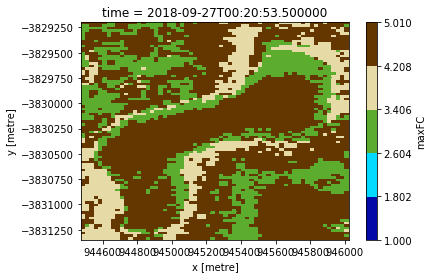

In [34]:
%matplotlib inline
WITmaps[image_index].plot(vmin = 1, vmax = 5.01, levels=6, colors = pal)#, add_colorbar=False)#,figsize=(8,12))
plt.show()

In [35]:
outfilename = f'{file_num}_{image_date}'

In [36]:
geotiff_WITmaps = WITmaps.isel(time=image_index).to_dataset()
geotiff_WITmaps.attrs = WITmaps.attrs

In [37]:
#transfer datatype to uint8 for ArcGIS import
geotiff_WITmaps_8 = geotiff_WITmaps.astype('uint8')
geotiff_WITmaps_8.attrs = WITmaps.attrs

In [38]:
Output_loc+outfilename

'/g/data/r78/rjd547/CEWO_Project/prototyping_outputs/9_2018-09-27'

In [39]:
datacube.helpers.write_geotiff(Output_loc+outfilename+'.tif', geotiff_WITmaps_8)